In [46]:
from ROOT import TMVA, TFile, TTree, TCut, TString
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Concatenate, Dense, LSTM, Input, Reshape, Dropout, RNN, BatchNormalization
from tensorflow.keras.optimizers import Adagrad, SGD, RMSprop, Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from IPython.display import display
import graphviz
from numba import cuda
from array import array
import pickle
import scikitplot as skplt
import seaborn as sns
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule
from math import sqrt

Load signal and background trees

In [2]:
def nextPowerTwo(n):
    n=n-1
    n=n>>1|n
    n=n>>2|n
    n=n>>4|n
    n=n>>8|n
    n=n>>16|n
    n=n+1
    return(n)

In [3]:
def min_max_renormal(numpy_array):
    mydf=pd.DataFrame(data=numpy_array)
    normalize_df=(mydf-mydf.min())/(mydf.max()-mydf.min())
    normalize_np=normalize_df.values
    print(normalize_np)
    return(normalize_np)

In [4]:
signalFile=TFile.Open("../sample-0711/sig_bbTotal.root")
backgroundFile=TFile.Open("../sample-0711/bkg_total.root")

In [5]:
signalTree=signalFile.Get("ntup")
backgroundTree=backgroundFile.Get("ntup")

In [6]:
signalNum=signalTree.GetEntries()
backgroundNum=backgroundTree.GetEntries()
print("signal events number before cut is: ",signalNum)
print("background events number before cut is: ",backgroundNum)

signal events number before cut is:  379199
background events number before cut is:  18069795


Convert minitree into numpy

In [29]:
signalArray=signalTree.AsMatrix(["weight","is_ee","is_mm","BDT_Region1","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
#signalArray=signalTree.AsMatrix(["weight","is_em","is_me","bjet_0_eta","bjet_1_pt","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                #"bb_pt","bb_deltar","bb_deltaeta","met_sig","met_phi","mt_lep0_met","mt_lep1_met"])
    
#backgroundArray=backgroundTree.AsMatrix(["weight","is_em","is_me","bjet_0_eta","bjet_1_pt","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                #"bb_pt","bb_deltar","bb_deltaeta","met_sig","met_phi","mt_lep0_met","mt_lep1_met"])
backgroundArray=backgroundTree.AsMatrix(["weight","is_ee","is_mm","BDT_Region1","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
    
print(signalArray.shape)

(379199, 25)


In [30]:
print("signal yield before cut is: ",sum(signalArray[:,0]))
print("background yield before cut is:",sum(backgroundArray[:,0]))

signal yield before cut is:  15.600508562739876
background yield before cut is: 2169748.186742322


In [9]:
dataSignal=pd.DataFrame(data=signalArray[:,4:],columns=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])

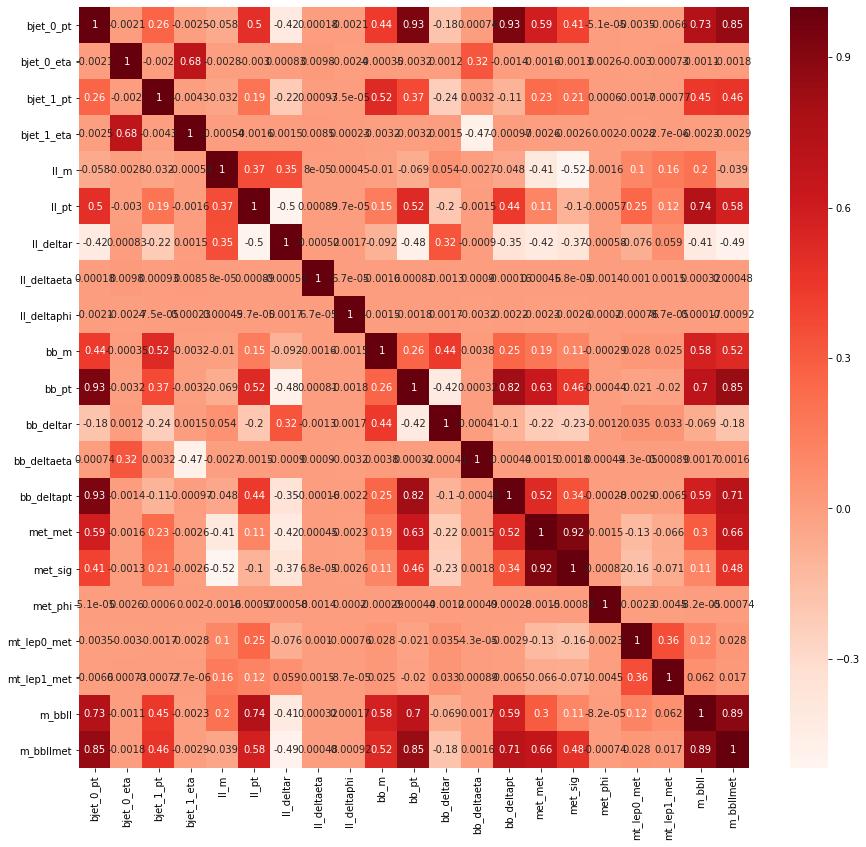

In [10]:
plt.figure(figsize=(15,14))
cor = dataSignal.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0711/corr_sig.eps', format='eps', dpi=500)
plt.show()

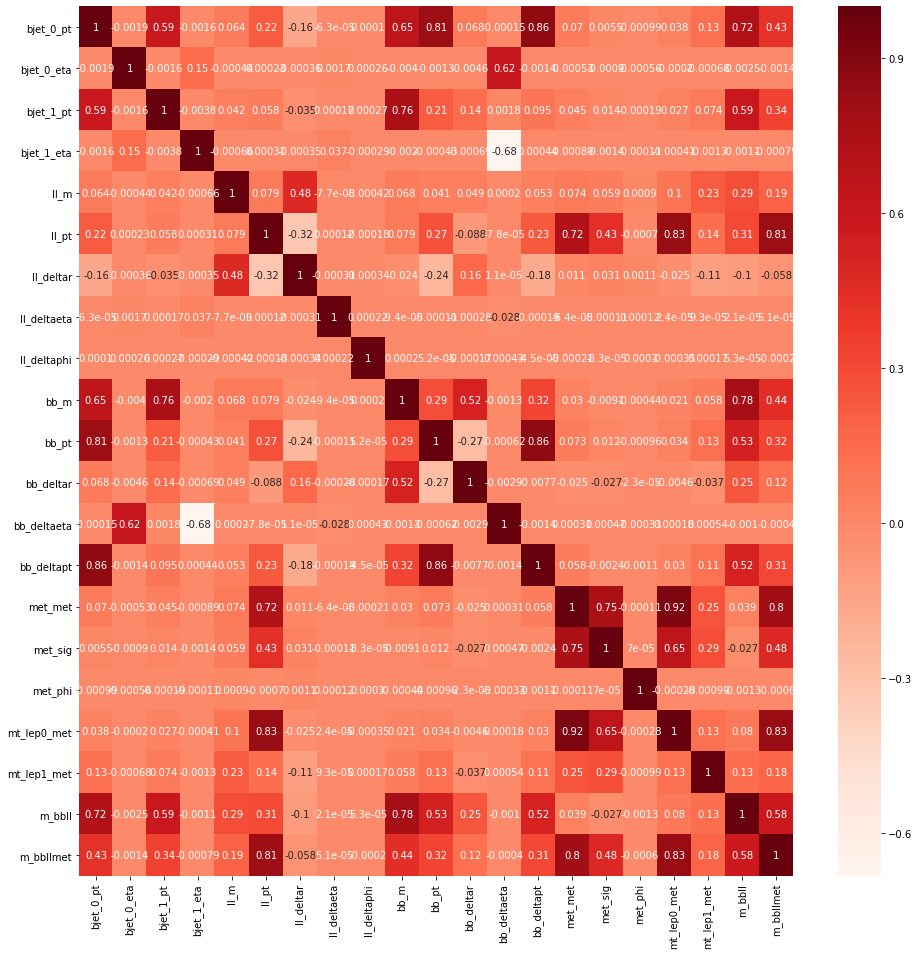

In [11]:
dataBackground=pd.DataFrame(data=backgroundArray[:,4:],columns=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
plt.figure(figsize=(16,16))
cor = dataBackground.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0711/corr_bkg.eps', format='eps', dpi=500)
plt.show()



In [12]:
print(signalArray)

[[ 2.01644220e-07  0.00000000e+00  0.00000000e+00 ...  8.16832910e+03
   1.01459575e+06  1.15864900e+06]
 [ 4.65245464e-05  0.00000000e+00  0.00000000e+00 ...  4.82755898e+04
   4.13342219e+05  5.49812625e+05]
 [ 4.08301212e-06  0.00000000e+00  1.00000000e+00 ...  2.39445947e+03
   4.90221562e+05  9.90220812e+05]
 ...
 [ 6.96462243e-07  1.00000000e+00  0.00000000e+00 ...  4.17481328e+04
   8.63429250e+05  8.78042938e+05]
 [ 8.11937758e-07  0.00000000e+00  1.00000000e+00 ...  2.02780938e+04
   7.03278562e+05  8.30059688e+05]
 [-3.84479825e-07  0.00000000e+00  1.00000000e+00 ...  2.43024629e+04
   5.73283750e+05  9.84956125e+05]]


In [13]:
print(signalArray[:,1])

[0. 0. 0. ... 1. 0. 0.]


Add signal Region cuts $m_{jj}>300$ Gev and $|\Delta(y_{jj})|>2.0$.

In [31]:
signalSample2=signalArray[(abs(signalArray[:,8])>75000.0)&((signalArray[:,1]==1)|(signalArray[:,2]==1))]
backgroundSample2=backgroundArray[(abs(backgroundArray[:,8])>75000.0)&((backgroundArray[:,1]==1)|(backgroundArray[:,2]==1))]

In [32]:
print(len(signalSample2))
print(len(backgroundSample2))

52680
11425015


In [33]:
signalNum=len(signalSample2)
backgroundNum=len(backgroundSample2)
print("signal event number after cut is: ",signalNum)
print("background event number after cut is:",backgroundNum)
print("signal yield after cut is: ",sum(signalSample2[:,0]))
print("background yield after cut is:",sum(backgroundSample2[:,0]))
SBratio=sum(signalSample2[:,0])/sum(backgroundSample2[:,0])
print("S/B ratio is: ",SBratio)
SigYield=sum(signalSample2[:,0])
BkgYield=sum(backgroundSample2[:,0])

signal event number after cut is:  52680
background event number after cut is: 11425015
signal yield after cut is:  0.4901765247906553
background yield after cut is: 960273.1071347836
S/B ratio is:  5.104553289565926e-07


In [34]:
signalSample3=signalSample2[(signalSample2[:,13]>80000)&(signalSample2[:,13]<150000)&(signalSample2[:,15]<2.8)]
backgroundSample3=backgroundSample2[(backgroundSample2[:,13]>80000)&(backgroundSample2[:,13]<150000)&(backgroundSample2[:,15]<2.8)]

In [35]:
print(len(signalSample3))
print(len(backgroundSample3))

42599
2589435


In [36]:
signalNum=len(signalSample3)
backgroundNum=len(backgroundSample3)
print("signal event number after cut is: ",signalNum)
print("background event number after cut is:",backgroundNum)
print("signal yield after cut is: ",sum(signalSample3[:,0]))
print("background yield after cut is:",sum(backgroundSample3[:,0]))
SBratio=sum(signalSample3[:,0])/sum(backgroundSample3[:,0])
print("S/B ratio is: ",SBratio)
SigYield1=sum(signalSample3[:,0])
BkgYield1=sum(backgroundSample3[:,0])

signal event number after cut is:  42599
background event number after cut is: 2589435
signal yield after cut is:  0.3815168325457166
background yield after cut is: 213351.34065594772
S/B ratio is:  1.7882092110260233e-06


In [37]:
signalSample=signalSample3[(signalSample3[:,3]>0.8)]
backgroundSample=backgroundSample3[(backgroundSample3[:,3]>0.8)]

In [38]:
print(len(signalSample))
print(len(backgroundSample))

33640
149316


In [39]:
signalNum=len(signalSample)
backgroundNum=len(backgroundSample)
print("signal event number after cut is: ",signalNum)
print("background event number after cut is:",backgroundNum)
print("signal yield after cut is: ",sum(signalSample[:,0]))
print("background yield after cut is:",sum(backgroundSample[:,0]))
SBratio=sum(signalSample[:,0])/sum(backgroundSample[:,0])
print("S/B ratio is: ",SBratio)
SigYield1=sum(signalSample[:,0])
BkgYield1=sum(backgroundSample[:,0])

signal event number after cut is:  33640
background event number after cut is: 149316
signal yield after cut is:  0.2744712018624422
background yield after cut is: 6104.84067542932
S/B ratio is:  4.495960115177619e-05


Split datasets into training and testing subsets

In [40]:
trainingRatio=0.8
sigTrainNum=int(signalNum*0.8)
backgroundTrainNum=int(backgroundNum*0.8)
sigTestNum=signalNum-sigTrainNum
backgroundTestNum=backgroundNum-backgroundTrainNum
print("training signal events number is: ",sigTrainNum)
print("testing signal events number is: ",sigTestNum)
print("training background events number is: ",backgroundTrainNum)
print("testing background events number is: ",backgroundTestNum)


training signal events number is:  26912
testing signal events number is:  6728
training background events number is:  119452
testing background events number is:  29864


In [41]:
signal_row=np.arange(0,signalNum-1,1)
background_row=np.arange(0,backgroundNum-1,1)
signal_train_row=np.random.choice(signal_row,size=sigTrainNum,replace=False)
background_train_row=np.random.choice(background_row,size=backgroundTrainNum,replace=False)
label_signal_train=np.ones((sigTrainNum,1))
label_background_train=np.zeros((backgroundTrainNum,1))
label_signal_test=np.ones((sigTestNum,1))
label_background_test=np.zeros((backgroundTestNum,1))
signalTrain=signalSample[signal_train_row,:]
signalTest=np.delete(signalSample,signal_train_row,axis=0)
backgroundTrain=backgroundSample[background_train_row,:]
backgroundTest=np.delete(backgroundSample,background_train_row,axis=0)
signalTrain=np.concatenate((label_signal_train,signalTrain),axis=1)
backgroundTrain=np.concatenate((label_background_train,backgroundTrain),axis=1)
signalTest=np.concatenate((label_signal_test,signalTest),axis=1)
backgroundTest=np.concatenate((label_background_test,backgroundTest),axis=1)
ratio=sum(signalTrain[:,1])/sum(backgroundTrain[:,1])
signalTrain[:,1]=signalTrain[:,1]/ratio
print(backgroundTest)
print(ratio)

[[ 0.00000000e+00  3.84156853e-02  1.00000000e+00 ...  1.08635805e+05
   4.31527125e+05  4.67892875e+05]
 [ 0.00000000e+00  1.31459547e-02  1.00000000e+00 ...  7.22172188e+04
   3.47012656e+05  4.03537125e+05]
 [ 0.00000000e+00 -2.16596449e-02  0.00000000e+00 ...  8.89540234e+03
   5.31927625e+05  5.54434750e+05]
 ...
 [ 0.00000000e+00 -2.74684799e-02  0.00000000e+00 ...  9.60216250e+04
   3.14398094e+05  5.68865500e+05]
 [ 0.00000000e+00 -1.07982989e-02  1.00000000e+00 ...  9.78951641e+04
   4.25366844e+05  4.55899469e+05]
 [ 0.00000000e+00  2.51526082e-02  1.00000000e+00 ...  7.83921016e+04
   2.60410953e+05  3.66607344e+05]]
4.5554976673270956e-05


In [42]:
dataTrain=np.vstack((signalTrain,backgroundTrain))
dataTest=np.vstack((signalTest,backgroundTest))
np.random.shuffle(dataTrain)
np.random.shuffle(dataTest)
dataTrainLabel=dataTrain[:,0]
dataTrainWeight=dataTrain[:,1]
dataTrainSample=dataTrain[:,5:]
dataTestLabel=dataTest[:,0]
dataTestWeight=dataTest[:,1]
dataTestSample=dataTest[:,5:]
tf.cast(dataTrainLabel,tf.float32)
tf.cast(dataTrainSample,tf.float32)

<tf.Tensor 'Cast_1:0' shape=(146364, 21) dtype=float32>

Signal and background training sets should have same yield in training

(146364,)
(146364,)


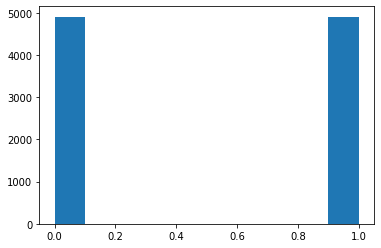

In [43]:
plt.hist(dataTrain[:,0],weights=dataTrainWeight)
print(dataTrainWeight.shape)
dataTrainWeight=dataTrainWeight.transpose()
print(dataTrainWeight.shape)
classweight = {0: 19.75,
                1: 1.}

Build model

In [44]:
dataTrainSample1=min_max_renormal(dataTrainSample)

[[0.0455512  0.48750594 0.04865335 ... 0.08434986 0.03733994 0.04462133]
 [0.04548572 0.40229695 0.22160651 ... 0.03875874 0.07517638 0.07531397]
 [0.07201571 0.36268839 0.24572786 ... 0.100124   0.05706572 0.07005504]
 ...
 [0.11262799 0.36611553 0.01133951 ... 0.13459449 0.16038387 0.16442265]
 [0.06560163 0.15207618 0.02399432 ... 0.07694963 0.02760152 0.03927827]
 [0.12961975 0.44819465 0.30421089 ... 0.03557053 0.06679346 0.08313205]]


In [53]:
model = Sequential()
model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu",
    input_dim=21))
model.add(BatchNormalization(momentum=0.5, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(BatchNormalization(momentum=0.5, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(BatchNormalization(momentum=0.5, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(BatchNormalization(momentum=0.5, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(BatchNormalization(momentum=0.5, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))

# Set loss, optimizer and evaluation metrics
model.compile(
     loss="binary_crossentropy",
     #optimizer=Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
      #optimizer='adam',
     optimizer=SGD(lr=0.001, momentum=0.5, decay=1e-6, nesterov=True),
     metrics=["acc"])

In [54]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='acc',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')

In [ ]:
model.save('model_HHZZ.h5')
model.summary()

In [55]:
model.fit(dataTrainSample1,dataTrainLabel,batch_size=50, epochs=30,
          sample_weight=dataTrainWeight,
          callbacks=[early_stopping])

Epoch 1/30
146364/146364 [==============================] - 10s 70us/sample - loss: 1.5529 - acc: 0.7540
Epoch 2/30
146364/146364 [==============================] - 10s 69us/sample - loss: 1.0603 - acc: 0.4816
Epoch 3/30
146364/146364 [==============================] - 10s 69us/sample - loss: 2.1297 - acc: 0.5874
Epoch 4/30
120150/146364 [=======================>......] - ETA: 1s - loss: 6.1890 - acc: 0.1870

KeyboardInterrupt: 

In [ ]:
signalSample1=min_max_renormal(signalSample[:,1:])
backgroundSample1=min_max_renormal(backgroundSample[:,1:])

In [ ]:
signalNN=model.predict(signalSample1)
backgroundNN=model.predict(backgroundSample1)
plt.hist(signalNN,bins=20)
plt.hist(backgroundNN,bins=20)
NNTrainScore=model.predict(dataTrainSample1)

In [ ]:
backgroundNN=model.predict(backgroundSample1)
plt.hist(backgroundNN,bins=20)

Save NN model to h5 file

In [ ]:
model.save('model_HHZZ.h5')
model.summary()

In [ ]:
signalNNScore=model.predict(signalSample1)
#backgroundNNScore=model.predict(backgroundArray[:,1:])
print(signalNNScore)

In [ ]:
plt.hist(signalNNScore,bins=20)

In [ ]:
def baseline_model():
    model = Sequential()
    model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu",
         input_dim=21))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))
    model.compile(
     loss="binary_crossentropy",
     optimizer="adam",
     metrics=["accuracy"])
    return model

In [ ]:
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=30, batch_size=50, verbose=False)
estimator.fit(dataTrainSample1,dataTrainLabel,sample_weight=dataTrainWeight)
perm = PermutationImportance(estimator, random_state=1).fit(dataTrainSample1,dataTrainLabel)

In [ ]:
eli5.show_weights(perm,feature_names=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])

In [56]:
cuda.select_device(0)
cuda.close()

In [58]:
varName=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"]
BDTtrain=xgb.DMatrix(dataTrainSample,label=dataTrainLabel,weight=dataTrainWeight,feature_names=varName)
BDTtest=xgb.DMatrix(dataTestSample,label=dataTestLabel,weight=dataTestWeight,feature_names=varName)
BDTSignal=xgb.DMatrix(signalSample[:,4:],feature_names=varName)
BDTBackground=xgb.DMatrix(backgroundSample[:,4:],feature_names=varName)
param = {'max_depth': 4, 'eta':0.1,'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 16
param['eval_metric'] = 'auc'
param['tree_method'] = 'gpu_hist'
param['grow_policy'] = 'depthwise'
#param['subsample']=0.9
evallist = [(BDTtest, 'eval'), (BDTtrain, 'train')]
#eta_list=[0.1]*10+[0.05]*20+[0.02]*40+[0.01]*930

In [59]:
num_round = 1000
GBDT = xgb.train(param, BDTtrain, num_round, evallist,early_stopping_rounds=5)

[0]	eval-auc:0.723365	train-auc:0.764247
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 5 rounds.
[1]	eval-auc:0.742204	train-auc:0.777966
[2]	eval-auc:0.746282	train-auc:0.781845
[3]	eval-auc:0.756602	train-auc:0.788461
[4]	eval-auc:0.761936	train-auc:0.791873
[5]	eval-auc:0.772269	train-auc:0.800752
[6]	eval-auc:0.773226	train-auc:0.804631
[7]	eval-auc:0.775582	train-auc:0.80813
[8]	eval-auc:0.776179	train-auc:0.811237
[9]	eval-auc:0.777537	train-auc:0.815612
[10]	eval-auc:0.777979	train-auc:0.816131
[11]	eval-auc:0.781031	train-auc:0.82114
[12]	eval-auc:0.783402	train-auc:0.824506
[13]	eval-auc:0.786088	train-auc:0.828306
[14]	eval-auc:0.787582	train-auc:0.830747
[15]	eval-auc:0.788683	train-auc:0.833476
[16]	eval-auc:0.789925	train-auc:0.835484
[17]	eval-auc:0.792008	train-auc:0.837899
[18]	eval-auc:0.793726	train-auc:0.841192
[19]	eval-auc:0.79564	train-auc:0.844223
[20]	eval-auc:0.796449	train-au

[191]	eval-auc:0.818807	train-auc:0.926798
[192]	eval-auc:0.818821	train-auc:0.92702
[193]	eval-auc:0.818849	train-auc:0.927225
[194]	eval-auc:0.818791	train-auc:0.927096
[195]	eval-auc:0.818748	train-auc:0.927136
[196]	eval-auc:0.818616	train-auc:0.927297
[197]	eval-auc:0.81878	train-auc:0.927448
[198]	eval-auc:0.818744	train-auc:0.927543
[199]	eval-auc:0.81859	train-auc:0.928
[200]	eval-auc:0.81863	train-auc:0.928456
[201]	eval-auc:0.8185	train-auc:0.928744
[202]	eval-auc:0.818321	train-auc:0.928637
[203]	eval-auc:0.818231	train-auc:0.928691
[204]	eval-auc:0.817896	train-auc:0.929142
[205]	eval-auc:0.818017	train-auc:0.929577
[206]	eval-auc:0.817886	train-auc:0.929559
[207]	eval-auc:0.817888	train-auc:0.929678
[208]	eval-auc:0.818109	train-auc:0.929931
[209]	eval-auc:0.817855	train-auc:0.930106
[210]	eval-auc:0.817857	train-auc:0.930328
[211]	eval-auc:0.817876	train-auc:0.930288
[212]	eval-auc:0.81782	train-auc:0.930428
[213]	eval-auc:0.817552	train-auc:0.93053
[214]	eval-auc:0.81764

[383]	eval-auc:0.810136	train-auc:0.945511
[384]	eval-auc:0.810225	train-auc:0.945529
[385]	eval-auc:0.810039	train-auc:0.94563
[386]	eval-auc:0.809912	train-auc:0.94556
[387]	eval-auc:0.809823	train-auc:0.945475
[388]	eval-auc:0.809656	train-auc:0.945551
[389]	eval-auc:0.809573	train-auc:0.945592
[390]	eval-auc:0.809577	train-auc:0.945629
Stopping. Best iteration:
[385]	eval-auc:0.810039	train-auc:0.94563



In [ ]:
GBDT=pickle.load(open("../BDT_model/GBDT_HH_region1-0.01.pickle.dat", "rb"))

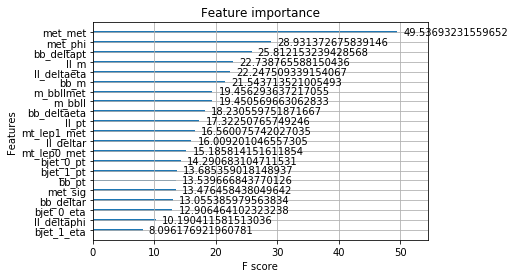

In [60]:
xgb.plot_importance(GBDT,importance_type="gain")
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0715/ranking-region1-gain.pdf', format='pdf', dpi=500)

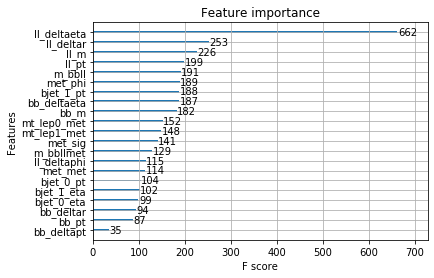

In [61]:
xgb.plot_importance(GBDT,importance_type="weight")
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0715/ranking-region1-weight.pdf', format='pdf', dpi=500)

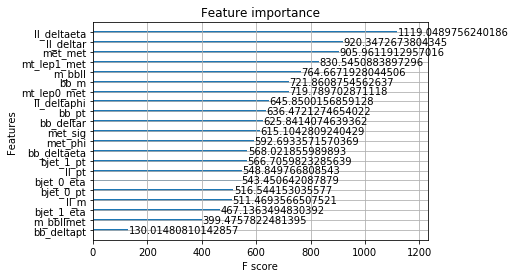

In [62]:
xgb.plot_importance(GBDT,importance_type="cover")
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0715/ranking-region1-coverage.pdf', format='pdf', dpi=500)

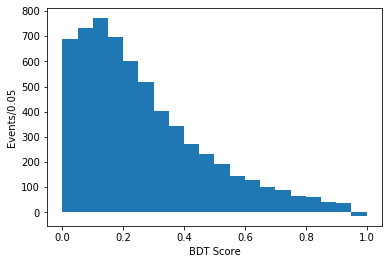

In [63]:
SignalScore=GBDT.predict(BDTSignal)
#plt.hist(SignalScore,bins=20)
BackgroundScore=GBDT.predict(BDTBackground)
plt.hist(BackgroundScore,bins=20,weights=backgroundSample[:,0])
plt.ylabel('Events/0.05')
plt.xlabel('BDT Score')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0715/BDT-region1-bkg.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
BackgroundScore=GBDT.predict(BDTBackground)
plt.hist(BackgroundScore,bins=20,range=[0.9, 1.0],weights=backgroundSample[:,0])
plt.ylabel('Events/0.05')
plt.xlabel('BDT Score')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0715/BDT-region1-bkg-high.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
BDTBackground1=xgb.DMatrix(backgroundArray[:,3:],feature_names=varName)
BackgroundScore1=GBDT.predict(BDTBackground1)
plt.hist(BackgroundScore1,bins=10,range=[0.9,1.0])
plt.ylabel('Events/0.05')
plt.xlabel('BDT Score')
plt.show()

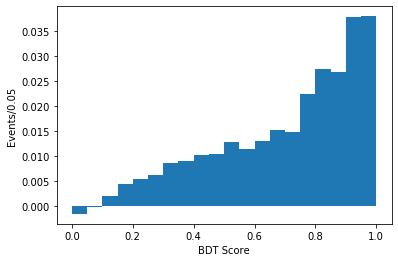

In [64]:
plt.hist(SignalScore,bins=20,weights=signalSample[:,0])
plt.ylabel('Events/0.05')
plt.xlabel('BDT Score')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0715/BDT-region1-sig.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
plot_tree(GBDT, num_trees=4)

(array([12987., 15151., 16048., 14538., 12680., 10507.,  8780.,  7448.,
         6143.,  5004.,  4283.,  3647.,  3125.,  2873.,  2669.,  2665.,
         2770.,  3145.,  4685.,  7216.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <a list of 20 Patch objects>)

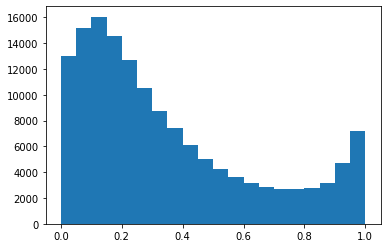

In [65]:
trainScore=GBDT.predict(BDTtrain)
testScore=GBDT.predict(BDTtest)
plt.hist(trainScore,bins=20)

In [66]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,trainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)

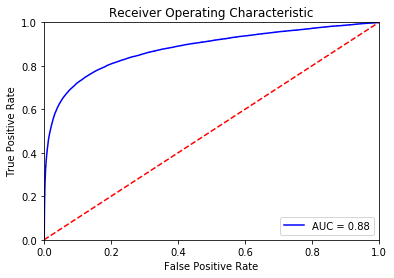

In [67]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0715/roc-region1-train.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,NNTrainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
pickle.dump(GBDT, open("../BDT_model/0716/GBDT_HH_region1_001.pickle.dat", "wb"))

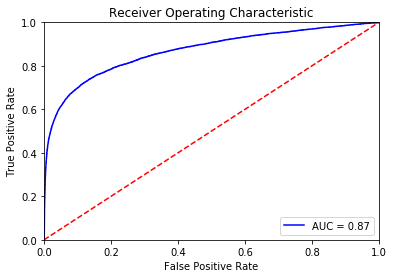

In [68]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTestLabel,testScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0715/roc-region1-test.pdf', format='pdf', dpi=500)
plt.show()

In [69]:
drv.init()
mod=SourceModule("""
__global__ void func1(double *a, double *b, double *c,double thre, int N)
{ 
  extern __shared__ double sharedMem[256];
  double x=0;
  int index=threadIdx.x+blockIdx.x*blockDim.x;
  int stride=blockDim.x*gridDim.x;
  sharedMem[threadIdx.x]=0;
  //if(index<N){
    //sharedMem[threadIdx.x]=b[index];
  //}
  for(int i=index;i<N;i=i+stride){
     if(a[i]>thre){
     sharedMem[threadIdx.x]+=b[i];
     }
  }
   
   __syncthreads();
   
   for(int offset=blockDim.x/2;offset>0;offset>>=1){
      if(threadIdx.x<offset){
      sharedMem[threadIdx.x]+=sharedMem[threadIdx.x+offset];
      }
      __syncthreads();
   }
   if(threadIdx.x==0){
      c[blockIdx.x]=sharedMem[0];
   }
   
}
""")
func1=mod.get_function("func1") 

In [70]:
def cuda_sum(nump1,nump2,th):
    num1=np.float64(nump1.copy(order='C'))
    num2=np.float64(nump2.copy(order='C'))
    thres=np.float64(th)
    nThreads=256
    nBlocks=68
    c1=np.zeros((68,1))
    N=np.int32(len(nump1))
    func1(drv.InOut(num1),drv.InOut(num2),drv.InOut(c1),thres,N,block=(nThreads, 1, 1),grid=(nBlocks,1))
    return(sum(c1))

In [71]:
resB=cuda_sum(BackgroundScore,backgroundSample[:,0],0.9)
resS=cuda_sum(SignalScore,signalSample[:,0],0.9)
SBratio1=resS/resB
Sig1=resS/sqrt(resB)
print("If cut BDT at 0.9, signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
      " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio1," Significance is: ",Sig1)
resB=cuda_sum(BackgroundScore,backgroundSample[:,0],0.95)
resS=cuda_sum(SignalScore,signalSample[:,0],0.95)
SBratio2=resS/resB
Sig2=resS/sqrt(resB)
print("If cut BDT at 0.95, signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
      " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio2," Significance is: ",Sig2)
resB=cuda_sum(BackgroundScore,backgroundSample[:,0],0.975)
resS=cuda_sum(SignalScore,signalSample[:,0],0.975)
SBratio3=resS/resB
Sig3=resS/sqrt(resB)
print("If cut BDT at 0.975, signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
      " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio3," Significance is: ",Sig3)

If cut BDT at 0.9, signal yield is: [0.07571206]  Eff is: [0.15445876]  background yield is: [23.37469237]  Eff is:  [2.4341713e-05]  S/B ratio is:  [0.00323906]  Significance is:  [0.01566001]


ValueError: math domain error

In [ ]:
i=0.1
eff=(0.8,0.7,0.6,0.5,0.4,0.3)
j=0
print(eff)
for i in np.arange(0,1,0.001):
    resS=cuda_sum(SignalScore,signalSample[:,0],i)
    ratio=resS/SigYield
    if((abs(ratio-0.8)<0.01)|(abs(ratio-0.7)<0.001)|(abs(ratio-0.6)<0.01)|(abs(ratio-0.5)<0.01)|(abs(ratio-0.4)<0.01)):
        print("sig Eff: ",ratio," and BDT cut is: ",i)
    

In [72]:
i=0.1
eff=(0.8,0.7,0.6,0.5,0.4,0.3)
j=0
k=0
t=0
min_diff=100
print(eff)
for i in np.arange(0,1,0.001):
    if(j>=6):
        break
    resS=cuda_sum(SignalScore,signalSample[:,0],i)
    ratio=resS/SigYield
    if(abs(ratio-eff[j])<0.05):
        t=1
        if(k==0):
            min_diff=100
        if(abs(ratio-eff[j])<min_diff):
            min_diff=abs(ratio-eff[j])
            BDT_cut=i
        k=k+1
           
    if(abs(ratio-eff[j])>0.05):
        if(t==1):
            j=j+1
            k=0
            t=0
            resB=cuda_sum(BackgroundScore,backgroundSample[:,0],BDT_cut)
            resS=cuda_sum(SignalScore,signalSample[:,0],BDT_cut)
            SBratio=resS/resB
            Sig=resS/sqrt(resB)
            print("If cut BDT at ",BDT_cut, "signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
              " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio," Significance is: ",Sig)
    
    

(0.8, 0.7, 0.6, 0.5, 0.4, 0.3)


In [ ]:
for i in np.arange(0,1,0.001):
    resB=cuda_sum(BackgroundScore,backgroundSample[:,0],i)
    print(resB/BkgYield)
    

In [ ]:
print("If cut at 0.9,   improvment is: ",SBratio1/SBratio)
print("If cut at 0.95,  improvment is: ",SBratio2/SBratio)
print("If cut at 0.975, improvment is: ",SBratio3/SBratio)